# Features creation
In this notebook, raw data is loaded and parsed in order to have similar data distributions in train and test sets.

After that, some basic features are computed and the results are saved into files.

In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import os
import sys
import datetime
import os.path
from calendar import monthrange

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
from cycler import cycler
import seaborn as sns
%matplotlib inline

from dateutil import rrule
from datetime import date
import re
 
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#ff0000', '#0000ff',   '#00ffff','#ffA300', '#00ff00', 
     '#ff00ff', '#990000', '#009999', '#999900', '#009900', '#009999'])

rc('font', size=16)
# rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=False)
rc('figure', figsize=(12, 10))
rc('axes', linewidth=.5)
rc('lines', linewidth=1.75)

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
sys.path.append("../src") # Adds directory to python modules path.
from models import utils
from data import distributions

In [3]:
# Configurations
TARGET_LABEL = 'item_cnt_month'
MONTH_INT_LABEL = 'date_block_num'
INDEX_COLUMNS = ['date_block_num', 'shop_id', 'item_id']
LAGS_WINDOWS = [1, 2, 3, 6, 12]
px_operations = ['last']
operations_dict = {
    'item_cnt_day': ['sum', 'min'],
    # 'date': ['first'],
    'item_price': px_operations
}

## Load data

In [4]:
train = utils.load_training(parse_dts=True)
train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
362720,2013-04-24,3,25,21415,349.000000,1
927211,2013-09-10,8,54,4282,286.459991,1
1146306,2013-12-26,11,28,20949,5.000000,35
183395,2013-02-21,1,31,17328,98.000000,1
1580307,2014-04-10,15,6,16795,299.000000,1


In [5]:
test = utils.load_test()
test.sample(5)

,ID,shop_id,item_id
120009,120009,53,3234
21705,21705,2,14809
204323,204323,39,18439
80654,80654,15,20455
60160,60160,25,1453


## Data cleaning

In [6]:
# Remove outliers
train = train[train['item_price'] > 0]
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 2000]

## Initial Data Parsing
We start by aggregating daily data into monthly data, taking some different measures.

In [7]:
train = train.groupby(INDEX_COLUMNS).agg(operations_dict)
# Parse dataframe
train.columns = ['%s_%s' % c for c in train.columns]
train = train.rename(columns={'item_cnt_day_sum': TARGET_LABEL})
train = train.reset_index()
# Show sample of rows
train.sample(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_day_min,item_price_last
689063,12,4,5036,2,1,1999.0
269118,4,31,14010,1,1,58.0
1183496,22,47,6426,1,1,2499.0
1063780,19,57,2124,1,1,599.0
750172,13,17,3280,1,1,299.0
862281,15,35,2808,11,1,999.0
511917,8,54,15257,1,1,1199.0
135881,2,18,6352,2,1,1949.0
1421575,28,15,3641,1,1,299.0
603226,10,42,19596,1,1,949.0


Now, before computing features, the data distributions should be fixed in order to be similar in train and test sets.

In [8]:
# train, test = distributions.fix_distributions(train, test, TARGET_LABEL)
train = distributions.fix_train_distribution(train, TARGET_LABEL)

In order to compute features for train and test sets at the same time, it will be appended to the train set.

In [9]:
# Append
test['date_block_num'] = train['date_block_num'].max() + 1
data_df = train.append(test.drop('ID', axis=1), sort=True)
del train
del test

In [10]:
# Downcast data
dtypes = {
    'date_block_num': np.int8,
    'item_cnt_day_min': np.float16,
    'item_id': np.int16,
    'shop_id': np.int8,
    'item_price_last': np.float16,
    'item_cnt_month': np.float32
}
for c, tp in dtypes.items():
    data_df[c] = data_df[c].astype(tp)
    
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 1614236 to 214199
Data columns (total 6 columns):
date_block_num      int8
item_cnt_day_min    float16
item_cnt_month      float32
item_id             int16
item_price_last     float16
shop_id             int8
dtypes: float16(2), float32(1), int16(1), int8(2)
memory usage: 212.2 MB


Now we are in conditions to compute features.

The features can be split into these categories:

    1. Lag features: related to previous sales
    2. Prices features: related to previous prices
    3. Date features: related to current month

In [11]:
def last_true_idx(arr):
    trues = np.argwhere(arr)
    return np.nan if len(trues) == 0 else trues[-1]


def first_true_idx(arr):
    trues = np.argwhere(arr)
    return np.nan if len(trues) == 0 else trues[0]


class Features:
    
    def __init__(self, df):
        self.df = df
        
    def lag_feature(self, column, lags, drop=False):
        for l in lags:
            lag_df = self.df[INDEX_COLUMNS + [column]]
            lag_df[MONTH_INT_LABEL] += l
            lag_df = lag_df.rename(columns={column: '%s_L%s' % (column, l)})
            self.df = self.df.merge(lag_df, on=INDEX_COLUMNS, how='left')
        
        if drop:
            self.drop_column(column)
            
    def drop_column(self, c):
        self.df.drop(c, axis=1, inplace=True)
        
    def mean_encode(self, gb_columns, label, lags):
        month_avg = self.df.groupby(gb_columns)[TARGET_LABEL].mean()
        month_avg.name = label
        month_avg = month_avg.dropna().reset_index()
        self.df = self.df.merge(month_avg, on=gb_columns, how='left')
        self.df[label] = self.df[label].astype(np.float16)
        self.lag_feature(label, lags, drop=True)
        
    def add_price_trend(self, operation, label):
        op_dict = {'item_price_last_L1': operation}
        df = self.df.groupby([MONTH_INT_LABEL, 'item_id']).agg(op_dict)
        df = df.astype(np.float32).unstack().ffill(limit=6)
        df -= df.shift(1)
        df = df.stack()
        df.columns = [label]
        df[label] = df[label].astype(np.float16)
        df = df.reset_index()
        self.df = self.df.merge(df, on=[MONTH_INT_LABEL, 'item_id'], how='left')
        
    def add_cumulative_sales(self, by_column, name, dtype):
        res_df = pd.pivot_table(
            self.df,
            values=TARGET_LABEL,
            index=MONTH_INT_LABEL,
            columns=['shop_id', by_column],
            aggfunc='sum'
        )
        res_df = res_df.clip(lower=0.0).iloc[:-1].cumsum().ffill()
        res_df = res_df.unstack().dropna()
        res_df = res_df[res_df != 0.0]
        res_df.name = name
        res_df = res_df.reset_index()
        on = [c for c in res_df.columns if c != name]
        self.df = self.df.merge(res_df, on=on, how='left')
        # Lag feature by one month
        self.lag_feature(name, [1], drop=True)
        # Final parsing
        lag_name = '%s_L1' % name
        self.df[lag_name] = self.df[lag_name].fillna(0.0).astype(dtype)
    
    def sales_happened(self, idx):
        """ Computes months when there were sales """
        clipped_df = self.df[idx + [MONTH_INT_LABEL, TARGET_LABEL]]
        clipped_df[TARGET_LABEL] = clipped_df[TARGET_LABEL].clip(lower=0.0)
        # Re-shape data
        pt = pd.pivot_table(
            clipped_df,
            index=MONTH_INT_LABEL,
            values=TARGET_LABEL,
            columns=idx,
            aggfunc='sum'
        )
        pt.replace(0.0, np.nan, inplace=True)
        pt.dropna(how='all', axis=1, inplace=True)
        
        return ~pt.isnull()
    
    def apply_sales_func(self, idx, name, func):
        # Get months when there were sales
        pt = self.sales_happened(idx)
        # Compute last true value
        pt = pt.rolling(len(pt), min_periods=0).apply(func, raw=True)
        # Lag one month
        pt = pt.shift(1)
        # Stack all columns
        while isinstance(pt, pd.DataFrame):
            pt = pt.stack()
        # Last parsing
        pt.name = name
        pt = pt.dropna().reset_index()
        pt[name] = pt[MONTH_INT_LABEL] - pt[name]
        # Merge
        self.df = self.df.merge(pt, on=idx + [MONTH_INT_LABEL], how='left')
    
    def add_last_sale(self, idx, name):
        self.apply_sales_func(idx, name, last_true_idx)
        
    def add_first_sale(self, idx, name):
        self.apply_sales_func(idx, name, first_true_idx)

    @property
    def last_month(self):
        return self.df['date_block_num'].max()
    
    @property
    def train(self):
        return self.df[self.df['date_block_num'] < self.last_month]
    
    @property
    def test(self):
        return self.df[self.df['date_block_num'] == self.last_month].drop(TARGET_LABEL, axis=1)


In [12]:
data = Features(data_df)
del data_df

## Item categories
Add item categories features to the features DataFrame

In [13]:
# Load files
data_dir = utils.get_data_dir()
items_dtype = {
    'item_id': np.int16, 'item_category_id': np.int8,
    'in_PC': np.float16, 'in_version': np.float16, 'icn_games': np.float16,
    'type_code': np.int8, 'subtype_code': np.int8,
    'meta_cat': np.int8
}
shops_dtype = {
    'shop_id': np.int8,
    'sn_Moscow': np.float16,
    'city_code': np.int8,
}
items = pd.read_csv(data_dir + '/processed/items.csv', dtype=items_dtype)
shops = pd.read_csv(data_dir + '/processed/shops.csv', dtype=shops_dtype)

In [14]:
data.df = data.df.merge(items, on='item_id', how='left')
data.df = data.df.merge(shops, on='shop_id', how='left')

## Games Releases Dates

In [15]:
# Load data
columns = ['title', 'platform', 'release_year', 'release_month', 'release_day']
games_info = pd.read_csv(utils.get_data_dir() + '/external/ign.csv', usecols=columns)
items_raw = pd.read_csv(utils.get_data_dir() + '/raw/items.csv')
cats_raw = pd.read_csv(utils.get_data_dir() + '/raw/item_categories.csv')

In [16]:
# Get games items
items_raw = items_raw.merge(cats_raw, on='item_category_id', how='left')
games_cats = list(range(18, 32))
games_cats.remove(25)  # Remove acessories for games
games_items = items_raw[items_raw['item_category_id'].isin(games_cats)]
del items_raw
del cats_raw

In [17]:
# Clean names of some best sellers
corrections = {
    'Одни из нас [PS3, русская версия]': 'The Last of Us [PS3, Russian version]',
    'Одни из нас. Обновленная версия [PS4, русская версия]': 'The Last of Us Remastered [PS4, Russian version]',
    'Sims 3: Набор для новичков [PC, русская версия]': 'The Sims 3: Starter Pack [PC, Russian version]',
    'Need for Speed: Most Wanted (a Criterion Game) Limited Edition [PC, русская версия]': 'Need for Speed: Most Wanted [PC, Russian Version]',
    'InFAMOUS: Второй сын [PS4, русская версия]': 'Infamous Second Son [PS4, Russian Version]',
    'Метро. Луч надежды. Ограниченное издание [PC, русская версия]': 'Metro. Last Light. [PC, Russian Version]',
    'Sims 3: Райские острова (дополнение) [PC, русская версия]': 'The Sims 3: Island Paradise [PC, Russian Version]'
}
for old, new in corrections.items():
    games_items.loc[games_items.item_name == old, 'item_name'] = new

In [18]:
# Compute platform column
def get_translation(v):
    for p in ['PC', 'MAC', 'Android']:
        if p in v:
            return p
    return v.split('-')[1].strip()

translations = {v: get_translation(v) for v in games_items['item_category_name'].unique()}
games_items['platform'] = games_items['item_category_name'].apply(lambda x: translations[x])

In [19]:
# Manual fix some games names
# Resident Evil 2015
games_info.loc[games_info.title == 'Resident Evil', 'title'] = 'Resident Evil [2015]'
# Gauntlet 2015
games_info.loc[games_info.title == 'Gauntlet', 'title'] = 'Gauntlet [2015]'
# Fix FIFA 14 release date
games_info.loc[games_info.title == 'FIFA 14', 'release_month'] = 9
games_info.loc[games_info.title == 'FIFA 14', 'release_day'] = 23
# Fix X Rebirth release date
games_info.loc[games_info.title == 'X Rebirth', 'release_month'] = 11
games_info.loc[games_info.title == 'X Rebirth', 'release_day'] = 15
# Fix Sunset Overdrive release date
games_info.loc[games_info.title == 'Sunset Overdrive', 'release_year'] = 2014
games_info.loc[games_info.title == 'Sunset Overdrive', 'release_month'] = 10
games_info.loc[games_info.title == 'Sunset Overdrive', 'release_day'] = 31

In [20]:
# Slice games information to include years of training data (and 3 years before)
games_info = games_info[games_info['release_year'] >= 2010]
games_info = games_info[games_info['release_year'] <= 2015]

In [21]:
# Translate platform to same format as in items
translation = {
    'PlayStation 3': 'PS3',
    'PlayStation 4': 'PS4',
    'Xbox One': 'XBOX ONE',
    'Xbox 360': 'XBOX 360',
    'PlayStation Portable': 'PSP',
    'PlayStation Vita': 'PSVita',
    'Macintosh': 'MAC'
}
games_info['platform'] = games_info['platform'].apply(lambda x: translation.get(x, x))

In [22]:
def clean_string(s, rem_symbols=u",!?.;:-''()[]"):
    return s.translate(dict.fromkeys(map(ord, rem_symbols))).upper()

games_info['title_clean'] = games_info['title'].apply(clean_string)

In [23]:
# Find closest game name match
plat_games = {
    p: list(games_info[games_info['platform'] == p]['title_clean'].values)
    for p in games_info['platform'].unique()
}
matches_lst = []
for _, r in games_items.iterrows():
    name = r['item_name']
    plat = r['platform']
    # Remove square brackets and clean name
    name = clean_string(re.sub(r'\[[^\]]*\]', '', name))
    # Find match
    possibilities = plat_games.get(plat, [])
    matches = [p for p in possibilities if name in p or p in name]
    if len(matches) > 1:
        # If there is more than one match, select the one with the most similar length
        len_diffs = [abs(len(name) - len(m)) for m in matches]
        min_len_idx = len_diffs.index(min(len_diffs))
        match = matches[min_len_idx]
    elif len(matches) == 1:
        match = matches[0]
    else:
        match = ''
        
    # Add size constraint
    if abs(len(match) - len(name)) > 0.4 * len(name):
        match = ''
    matches_lst.append(match)

games_items['item_match'] = matches_lst

In [24]:
# Merge to get release dates information
items_mg = games_items[games_items.item_match != '']
games_mg = games_info.rename(columns={'title_clean': 'item_match'})
games_items = items_mg.merge(games_mg, on=['platform', 'item_match'])

In [25]:
cols = ['item_id', 'release_year', 'release_month', 'release_day']
data.df = data.df.merge(games_items[cols], how='left', on='item_id').sort_values(INDEX_COLUMNS)

In [26]:
dtypes = {'release_year': np.float16, 'release_month': np.float16, 'release_day': np.float16}
for c, dtp in dtypes.items():
    data.df[c] = data.df[c].astype(dtp)

In [27]:
# Add month and year
data.df['month'] = (data.df['date_block_num'] % 12 + 1).astype(np.int8)
data.df['year'] = (2013 + data.df['date_block_num'] // 12).astype(np.int16)

In [28]:
%%time
# Compute number of months until release (negative before release)
def months_diff(y0, m0, y1, m1):
    return (y1 - y0) * 12 + (m1 - m0)

def df_months_diff(r):
    return months_diff(r['release_year'], r['release_month'], r['year'], r['month'])


cols = ['release_year', 'release_month', 'year', 'month', 'item_category_id', 'meta_cat']
cols = cols + INDEX_COLUMNS + [TARGET_LABEL]
small_df = data.df[~np.isnan(data.df.release_year)][cols]
small_df['release_months'] = small_df.apply(df_months_diff, axis=1)

CPU times: user 41 s, sys: 282 ms, total: 41.3 s
Wall time: 41.3 s


In [29]:
def previous_months_encoding(df, idx, name, mean_window=12):
    pt = pd.pivot_table(
        df, 
        columns=idx, 
        index=MONTH_INT_LABEL, 
        values=TARGET_LABEL, 
        aggfunc='sum'
    )
    pt = pt.rolling(mean_window, min_periods=6).mean()
    # Lag one month
    pt = pt.shift(1)
    # Stack all columns
    while isinstance(pt, pd.DataFrame):
        pt = pt.stack()
    
    # Last parsing
    pt.name = name
    pt = pt.dropna().reset_index()
    
    return df.merge(pt, on=idx + [MONTH_INT_LABEL], how='left')

In [30]:
%%time
small_df = previous_months_encoding(small_df, ['release_months', 'shop_id'], 'release_shop')
small_df = previous_months_encoding(small_df, ['release_months', 'item_category_id'], 'release_cat')
small_df = previous_months_encoding(small_df, ['release_months', 'meta_cat'], 'release_metacat')

CPU times: user 1.34 s, sys: 8.7 ms, total: 1.35 s
Wall time: 1.35 s


In [31]:
%%time
small_df = previous_months_encoding(small_df, ['release_months', 'shop_id', 'item_category_id'], 'rel_shopcat')
small_df = previous_months_encoding(small_df, ['release_months', 'shop_id', 'meta_cat'], 'rel_shopmetacat')

CPU times: user 25.8 s, sys: 28.1 ms, total: 25.8 s
Wall time: 25.8 s


In [32]:
# Downcast
for c in ['release_months', 'release_shop', 'release_cat', 'release_metacat', 'rel_shopcat', 'rel_shopmetacat']:
    small_df[c] = small_df[c].astype(np.float16)

In [33]:
%%time
# Merge data
on = list(set(small_df.columns) & set(data.df.columns))
data.df = data.df.merge(small_df, on=on, how='left')

CPU times: user 9.93 s, sys: 3.01 s, total: 12.9 s
Wall time: 12.9 s


In [34]:
# Free memory
del small_df
to_drop = ['release_year', 'release_month', 'release_day', 'year']
data.df = data.df.drop(to_drop, axis=1)

## Lag features
Let's create columns with lag features, i.e., with value of sales n months before current month.

In [37]:
%%time
data.lag_feature(TARGET_LABEL, LAGS_WINDOWS)

CPU times: user 39.2 s, sys: 15.3 s, total: 54.5 s
Wall time: 54.5 s


In [38]:
%%time
data.lag_feature('item_cnt_day_min', [1], drop=True)

CPU times: user 8.08 s, sys: 3.77 s, total: 11.9 s
Wall time: 11.9 s


In [39]:
# Downcast
for c in ['%s_L%s' % (TARGET_LABEL, i) for i in LAGS_WINDOWS]:
    data.df[c] = data.df[c].astype(np.float16)

## Cumulative Sales Features

In [40]:
%%time
data.add_cumulative_sales('item_id', name='cum_sales', dtype=np.int16)

CPU times: user 27.9 s, sys: 11.4 s, total: 39.3 s
Wall time: 39.3 s


In [41]:
%%time
data.add_cumulative_sales('item_category_id', name='cum_cat_sales', dtype=np.int32)

CPU times: user 17 s, sys: 8.52 s, total: 25.5 s
Wall time: 25.5 s


In [42]:
%%time
data.add_cumulative_sales('meta_cat', name='cum_metacat_sales', dtype=np.int32)

CPU times: user 18 s, sys: 9.28 s, total: 27.3 s
Wall time: 27.3 s


## Prices features
Prices features will be, for each pair:
    - minimum price of last month
    - maximum price of last month
    - last price of last month

In [43]:
%%time
col_labels = ['item_price_' + op for op in px_operations]
for c in col_labels:
    # Add lag
    data.lag_feature(c, [1], drop=True)

CPU times: user 11.1 s, sys: 5.08 s, total: 16.2 s
Wall time: 16.2 s


In [44]:
%%time
# Add mean and min item price of previous month
index_cols = [MONTH_INT_LABEL, 'item_id']
px_df = data.df.groupby(index_cols).agg({'item_price_last_L1': ['mean', 'min']})
px_df = px_df.dropna(how='all')
px_df.columns = ['item_px_mean_L1', 'item_px_min_L1']
data.df = data.df.merge(px_df, on=index_cols, how='left')

CPU times: user 10 s, sys: 3.78 s, total: 13.8 s
Wall time: 13.8 s


In [45]:
%%time
data.add_price_trend('mean', 'price_mean_trend')
data.add_price_trend('min', 'price_min_trend')

CPU times: user 14.1 s, sys: 6.47 s, total: 20.5 s
Wall time: 20.5 s


## Date features

In [46]:
m_range = {}
m_weekdays = {}
for yy in [2013, 2014, 2015]:
    m_range[yy] = {}
    m_weekdays[yy] = {}
    for mm in range(1, 12 + 1):
        rng = monthrange(yy, mm)[1]
        m_range[yy][mm] = rng
        # Compute number of week days in month
        start = date(yy, mm, 1)
        end = date(yy, mm, rng)
        weekdays = rrule.rrule(
            rrule.DAILY, byweekday=range(0, 5), dtstart=start, until=end
        )
        m_weekdays[yy][mm] = len(list(weekdays))

m_ranges = [m_range[yy][mm] for yy in [2013, 2014, 2015] for mm in range(1, 12 + 1)]
m_weekend = [
    m_range[yy][mm] - m_weekdays[yy][mm] 
    for yy in [2013, 2014, 2015] for mm in range(1, 12 + 1)
]
data.df['month_range'] = data.df[MONTH_INT_LABEL].map(pd.Series(m_ranges)).astype(np.int8)
data.df['n_weekend'] = data.df[MONTH_INT_LABEL].map(pd.Series(m_weekend)).astype(np.int8)

In [47]:
%%time
data.add_first_sale(['shop_id', 'item_id'], name='first_sale')

CPU times: user 2min 52s, sys: 7.99 s, total: 3min
Wall time: 2min 59s


In [48]:
%%time
data.add_first_sale(['item_id'], name='item_first_sale')

CPU times: user 17.3 s, sys: 3.95 s, total: 21.2 s
Wall time: 20.9 s


In [49]:
%%time
data.add_last_sale(['item_id'], name='item_last_sale')

CPU times: user 18.4 s, sys: 3.78 s, total: 22.2 s
Wall time: 21.9 s


In [50]:
%%time
data.add_last_sale(['shop_id', 'item_id'], name='last_sale')

CPU times: user 2min 51s, sys: 7.65 s, total: 2min 58s
Wall time: 2min 58s


In [51]:
# Downcast columns
for c in ['first_sale', 'item_first_sale', 'item_last_sale', 'last_sale']:
    data.df[c] = data.df[c].astype(np.float16)

In [52]:
# Test 1
fs_df = data.df[['first_sale', 'item_first_sale']].dropna()
assert (fs_df['first_sale'] <= fs_df['item_first_sale']).eq(True).all()
del fs_df
# Test 2
ls_df = data.df[['last_sale', 'item_last_sale']].dropna()
assert (ls_df['item_last_sale'] <= ls_df['last_sale']).eq(True).all()
del ls_df
# Test 3
df = data.df[['last_sale', 'first_sale']].dropna()
assert (df['first_sale'] >= df['last_sale']).eq(True).all()
del df
# Test 4
df = data.df[['item_last_sale', 'item_first_sale']].dropna()
assert (df['item_first_sale'] >= df['item_last_sale']).eq(True).all()
del df

In [53]:
assert (data.df['first_sale'].dropna() > 0).eq(True).all()
assert (data.df['item_first_sale'].dropna() > 0).eq(True).all()
assert (data.df['item_last_sale'].dropna() > 0).eq(True).all()
assert (data.df['last_sale'].dropna() > 0).eq(True).all()

## Mean Encodings

In [54]:
%%time
# Month lag1 mean encoding
data.mean_encode(['date_block_num'], 'month_avg', [1, 12])

CPU times: user 28.1 s, sys: 14 s, total: 42.1 s
Wall time: 42.1 s


In [55]:
%%time
data.mean_encode(['date_block_num', 'item_id'], 'month_item_avg', [1, 2, 3, 6])

CPU times: user 59.2 s, sys: 29.1 s, total: 1min 28s
Wall time: 1min 28s


In [56]:
%%time
data.mean_encode(['date_block_num', 'shop_id'], 'month_shop_avg', [1, 2, 3, 6])

CPU times: user 57.1 s, sys: 29.3 s, total: 1min 26s
Wall time: 1min 26s


In [57]:
%%time
data.mean_encode(['date_block_num', 'item_category_id'], 'month_cat_avg', [1])

CPU times: user 21.7 s, sys: 12.2 s, total: 33.9 s
Wall time: 33.9 s


In [58]:
%%time
data.mean_encode(['date_block_num', 'shop_id', 'item_category_id'], 'month_shopcat_avg', [1])

CPU times: user 20.7 s, sys: 11.5 s, total: 32.2 s
Wall time: 32.2 s


In [59]:
%%time
data.mean_encode(['date_block_num', 'city_code'], 'month_city_avg', [1])

CPU times: user 21 s, sys: 11.5 s, total: 32.5 s
Wall time: 32.5 s


In [60]:
%%time
data.mean_encode(['date_block_num', 'item_id', 'city_code'], 'month_itemcity_avg', [1])

CPU times: user 26.2 s, sys: 12.9 s, total: 39.1 s
Wall time: 39.1 s


## Features correlations

In [61]:
corrs = data.df.sample(2**22).corr()

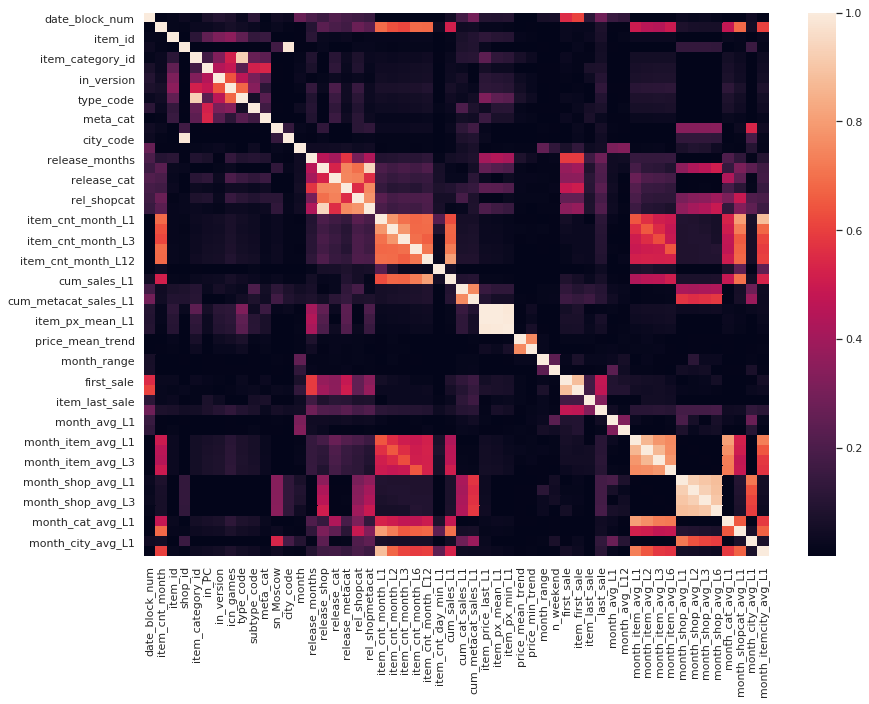

In [62]:
sns.set(rc={'figure.figsize':(14, 10)})
sns.heatmap(corrs.abs())

# Save features
Finally, split into train and test and save to hdf5 files.

In [63]:
data.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128139 entries, 0 to 11128138
Data columns (total 54 columns):
date_block_num           int8
item_cnt_month           float32
item_id                  int16
shop_id                  int8
item_category_id         int8
in_PC                    float16
in_version               float16
icn_games                float16
type_code                int8
subtype_code             int8
meta_cat                 int8
sn_Moscow                float16
city_code                int8
month                    int8
release_months           float16
release_shop             float16
release_cat              float16
release_metacat          float16
rel_shopcat              float16
rel_shopmetacat          float16
item_cnt_month_L1        float16
item_cnt_month_L2        float16
item_cnt_month_L3        float16
item_cnt_month_L6        float16
item_cnt_month_L12       float16
item_cnt_day_min_L1      float16
cum_sales_L1             int16
cum_cat_sales_L1      

In [64]:
# Save to HDF5 files
data_path = '../data/processed/'
data.train.to_hdf(data_path + 'train_features.h5', key='df', mode='w')
data.test.to_hdf(data_path + 'test_features.h5', key='df', mode='w')